In [68]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils


# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_properties(0))

cuda:0
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1070 Ti', major=6, minor=1, total_memory=8191MB, multi_processor_count=19)


6


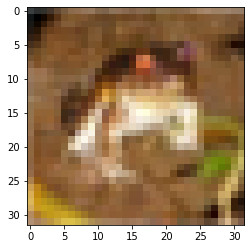

In [3]:
CIFAR10 = datasets.CIFAR10('data',transform=transforms.ToTensor())



#display the first image in the dataset and its label
plt.imshow(CIFAR10.__getitem__(0)[0].permute(1,2,0))
print(CIFAR10.__getitem__(0)[1])

#split the dataset into training, validation and test sets
length_training = CIFAR10.__len__()*0.8
length_validation = CIFAR10.__len__()*0.1

training = list(CIFAR10)[:int(length_training)]
validation = list(CIFAR10)[int(length_training):int(length_training+length_validation)]
test = list(CIFAR10)[int(length_training+length_validation):]

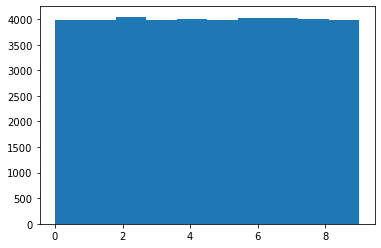

In [7]:

#plot the dirtribution of the labels in the training set
labels = [x[1] for x in training]
plt.hist(labels,bins=10)
plt.show()

We cam see that we are wroking with a very balanced data set.

Models in PyTorch
We'll train a convolutional neural network.

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3).to(device)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5).to(device)
        self.fc1 = nn.Linear(16*5*5,10).to(device)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = self.fc1(x)
        return x


def get_accuracy(model,data,train):
    model.cuda()
    if train:
        model.train()
    else:
        model.eval()
    correct = 0
    total = 0
    for images,labels in data:
        images,labels = images.to(device),labels
        outputs = model(images.unsqueeze(0))
        _,predicted = torch.max(outputs.data,1)
        total += 1
        correct += (predicted == labels).sum()
    return (100*correct/total)




In [27]:
def train(model, data, validation, batch_size, epochs, learning_rate = 0.01,weight_decay =0,momentum = 0.9):
    """
    :param model: the model to train
    :param data: the dataset to train on
    :param batch_size: the batch size
    :param epochs: the number of epochs
    :param learning_rate: the learning rate
    :param weight_decay: the weight decay
    :param momentum: the momentum
    :return: the trained model
    """
    losses = []
    iter = []
    train_acc = []
    val_acc = []    



    #define the loss function
    criterion = nn.CrossEntropyLoss()
    #define the optimizer
    optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)

    #images loader
    train_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=True)

    #train the model
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(train_loader):

            #move tensors to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            if images.size()[0] < batch_size:
                continue

            #forward pass
            else:
                model.train()

           
                #forward pass
                outputs = model(images)
                #compute the loss
                loss = criterion(outputs,labels)
                #backward pass
                loss.backward()
                #update the weights
                optimizer.step()
                #clear the gradients
                optimizer.zero_grad()

                #store current loss
                iter.append(i)
                losses.append(float(loss)/batch_size)
        #print training loss
        print("Training loss: ",losses[-1])
        #compute training accuracy
        train_acc.append(get_accuracy(model,data,train=True))
        #compute validation accuracy
        val_acc.append(get_accuracy(model,validation,train=False))


        
       

    


                
    return model,losses,iter,train_acc,val_acc
    




In [51]:
model = CNN()

model,losses,iter,train_acc,val_acc = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=10)

val_acc



Training loss:  0.01592793583869934
Training loss:  0.01527076005935669
Training loss:  0.014277247190475463
Training loss:  0.011520674228668213
Training loss:  0.01368920087814331
Training loss:  0.013647453784942627
Training loss:  0.012901455163955688
Training loss:  0.015098445415496826
Training loss:  0.012233890295028686
Training loss:  0.01172808289527893


[tensor(36.9400, device='cuda:0'),
 tensor(44.6800, device='cuda:0'),
 tensor(47.5200, device='cuda:0'),
 tensor(50.5400, device='cuda:0'),
 tensor(50.6600, device='cuda:0'),
 tensor(53.4200, device='cuda:0'),
 tensor(52.8000, device='cuda:0'),
 tensor(54.5400, device='cuda:0'),
 tensor(55.4400, device='cuda:0'),
 tensor(56.5800, device='cuda:0')]

In [84]:
#Adding more layers
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2,self).__init__()
        self.conv1 = nn.Conv2d(3,6,3,padding=1).to(device)
        self.bn1 = nn.BatchNorm2d(6).to(device)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,2,padding=1).to(device)
        self.bn2 = nn.BatchNorm2d(16).to(device)
        self.conv3 = nn.Conv2d(16,16,2,padding=1).to(device)
        self.bn3 = nn.BatchNorm2d(16).to(device)
        self.fc1 = nn.Linear(16*9*9,32).to(device)
        self.fc2 = nn.Linear(32,10).to(device)

    def forward(self,x):
        x = self.pool(torch.relu(self.conv1(x)))
        #print(x.size())
        x = torch.relu(self.conv2(x))
        #print(x.size())
        x = self.pool(torch.relu(self.conv3(x)))
        #print(x.size())
        
        
        x= x.view(-1,16*9*9)
        x = self.fc1(x)
       
        x = self.fc2(x)
        return x

In [85]:
model = CNN2()

model,losses,iter,train_acc,val_acc = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=10)

val_acc

Training loss:  0.015953435897827148
Training loss:  0.014709690809249878
Training loss:  0.016231139898300172
Training loss:  0.013264497518539429
Training loss:  0.010751591920852661
Training loss:  0.0131999409198761
Training loss:  0.009827327728271485
Training loss:  0.011649407148361206
Training loss:  0.011413370370864867
Training loss:  0.011770119667053222


[tensor(41.9800, device='cuda:0'),
 tensor(46.1400, device='cuda:0'),
 tensor(50.5200, device='cuda:0'),
 tensor(52.9000, device='cuda:0'),
 tensor(55.3000, device='cuda:0'),
 tensor(56.0600, device='cuda:0'),
 tensor(56.7600, device='cuda:0'),
 tensor(55.4600, device='cuda:0'),
 tensor(59.4800, device='cuda:0'),
 tensor(60.1600, device='cuda:0')]

Both model is far from overfitting. 

In [88]:
#saving the model
torch.save(model.state_dict(),'model.pt')

#loading the model
model.load_state_dict(torch.load('model.pt'))

#continuing training
model,losses,iter,train_acc,val_acc = train(model,training,validation,learning_rate=0.001,batch_size=100,epochs=10)

Training loss:  0.00994070827960968
Training loss:  0.00946922242641449
Training loss:  0.010766916275024414
Training loss:  0.00805833101272583
Training loss:  0.008845857977867126
Training loss:  0.008772277235984803
Training loss:  0.009214840531349182
Training loss:  0.006859980225563049
Training loss:  0.009334215521812439
Training loss:  0.012196717262268066
